# MNIST Classifier

This notebook illustrates the use of a `BaseModel` sub-class (`MNISTClassifier`) to classify `MNIST` data (28x28 images representing handwritten digits). All projects in this repository are based on the `BaseModel` abstraction, which provides a unified framework for defining three essential components: the data processing pipeline, the training/processing hyper-parameters (configuration), and the `keras.Model` architecture.

1. The first step is to initialize the model by providing all model-specific configurations (in this case, the `input_size` and the `labels`)
    - The constructor initializes the directories to save the model configuration and architecture weights
    - The `build` function is then called to instantiate the `keras.Model` instance
    - Both configuration and architecture weights are saved in the model directory (`pretrained_models/{name}`)
    
2. Once the model has been instantiated, it can be restored via the `get_pretrained` function, or by re-creating it with the same name
    - If a directory with the model name already exists, it will automatically restore the configuration, deserialize the `keras.Model` architecture, and load the expected checkpoint
    
3. The second step is to `compile` the model: this defines the optimizer, loss function, and metrics used during training
    - Generally, `BaseModel` sub-classes redefine this method or specify the `_default_loss` attribute, allowing compilation without additional parameters. Nevertheless, you can pass custom `{loss/metrics/optimizer}_config` as arguments
    
4. The final step before training is to load the dataset! The `get_dataset` method automatically loads the expected dataset based on its name (and possible additional configurations)

5. (Optional) A good practice is to verify the processing pipeline to ensure everything works as expected. For this purpose, check the last cells of this notebook, which allow proper visualization of the processing effects on data

6. Let's train the model! 😄 The `fit` method of the `BaseModel` class handles the creation of a `tf.data` pipeline that efficiently processes the given dataset before passing it to the `keras.Model.fit` method!
    - Additionally, the `fit` method incorporates custom callbacks to track training metrics and information, enabling better understanding and reproducibility
    
7. Once training is complete, the model is automatically saved, and you can immediately use it for prediction or evaluation!

## Imports + model initialization

In [2]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd

from keras import tree

from models import get_pretrained
from models.example import MNISTClassifier
from utils import set_display_options, plot, plot_multiple, plot_confusion_matrix
from utils.keras import show_version, ops
from utils.datasets import get_dataset, prepare_dataset, test_dataset_time

set_display_options()

model_name = 'mnist_classifier'
show_version()

Keras version : 3.8.0 - backend (tensorflow) : 2.18.0


In [5]:
input_shape = (28, 28, 1)
model = MNISTClassifier(input_size = input_shape, labels = list(range(10)), name = model_name)

print(model)


========== mnist_classifier ==========
Model :
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 18
- Number of parameters 	: 28048
- Optimizer 	: {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	: crossentropy

Already trained on 0 epochs (0 steps)

- Labels : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



In [6]:
model.summary()

Model: "cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1 (BatchNormalization)     │ (None, 28, 28, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation               │ (None, 28, 28, 16)     │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 16, 16, 16)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2 (BatchNormalization)     │ (None, 14, 14, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_1             │ (None, 14, 14, 16)     │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_2             │ (None, 32)             │             0 │
│ (CustomActivation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_layer (Dense)    │ (None, 10)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_activation_3             │ (None, 10)             │             0 │
│ (CustomActivation)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,048 (109.56 KB)

 Trainable params: 27,984 (109.31 KB)

 Non-trainable params: 64 (256.00 B)

## Model instanciation + dataset loading

Once initialized, the model can be restored just by passing its name as argument. Furthermore, all models are `Singleton`, meaning that if your model has already been restored, it will return the existing instance (and will not restore it) (*unless explicitely required via the `reload = True` argument*) !

In [4]:
model = get_pretrained(model_name) # Equivalent to `MNISTClassifier(name = model_name)`

model.compile()

print(model)

I0000 00:00:1742113341.868907    2850 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22444 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading weights from `pretrained_models/mnist_classifier/saving/ckpt-0000.weights.h5`
MNISTClassifier `mnist_classifier` initialized successfully !
Model compiled successfully !
- Optimizer 	: {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	: crossentropy
- Metric 	: accuracy


========== mnist_classifier ==========
Model :
- Inputs 	: (None, 28, 28, 1)
- Outputs 	: (None, 10)
- Number of layers 	: 18
- Number of parameters 	: 28048
- Optimizer 	: {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, '

In [7]:
ds = get_dataset('mnist', source = 'keras')

if isinstance(ds, dict):
    train, valid = ds['train'], ds['test']
    print(train)
    print(valid)
else:
    train, valid = ds
    print('train : {} - valid : {}'.format(
        tree.map_structure(ops.shape, train), tree.map_structure(ops.shape, valid)
    ))


train : ((60000, 28, 28), (60000,)) - valid : ((10000, 28, 28), (10000,))


## Training + history analysis

Note that the training has finished after 9 epochs, while 15 were expected. This is due to the `EarlyStopping` callback, allowing to stop the training when a convergence criterion is reached. In this case, no improvement of the `val_loss` during 3 (`patience`) epochs.

In [8]:
model.fit(
    train,
    validation_data = valid,
    epochs     = 15,
    batch_size = 64,
    
    additional_infos = {'dataset' : 'mnist'},
    
    add_early_stopping = True,
    patience = 3
)

Training config :
- x	:<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
- epochs	:15
- callbacks	:[<custom_train_objects.callbacks.history_callback.HistoryCallback object at 0x7fb6b82d6290>, <keras.src.callbacks.terminate_on_nan.TerminateOnNaN object at 0x7fb6219f20b0>, <keras.src.callbacks.early_stopping.EarlyStopping object at 0x7fb6219f3b50>, <custom_train_objects.callbacks.checkpoint_callback.CheckpointCallback object at 0x7fb6219f1d80>]
- initial_epoch	:0
- validation_data	:<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Epoch 1/15


I0000 00:00:1742113359.488837    5869 service.cc:148] XLA service 0x7fb4f8020580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742113359.488856    5869 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2025-03-16 09:22:39.511893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742113359.608389    5869 cuda_dnn.cc:529] Loaded cuDNN version 90300


 77/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2829 - loss: 2.1750

I0000 00:00:1742113360.833972    5869 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5658 - loss: 1.9021 - val_accuracy: 0.8730 - val_loss: 1.5887
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8663 - loss: 1.5994 - val_accuracy: 0.9729 - val_loss: 1.4892
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9438 - loss: 1.5209 - val_accuracy: 0.9762 - val_loss: 1.4858
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9509 - loss: 1.5132 - val_accuracy: 0.9782 - val_loss: 1.4825
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9530 - loss: 1.5099 - val_accuracy: 0.9813 - val_loss: 1.4805
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9583 - loss: 1.5043 - val_accuracy: 0.9820 - val_loss: 1.4792
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9583 - loss: 1.5039 - val_accuracy: 0.9814 - val_loss: 1.4800
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9617 - loss: 1.5005 - val_accuracy: 0.9834 - val_

<History epochs=11 steps=10318>

===== History =====
    accuracy      loss  val_accuracy  val_loss
0   0.700733  1.767139        0.8730  1.588653
1   0.902517  1.563106        0.9729  1.489161
2   0.944650  1.519497        0.9762  1.485828
3   0.951733  1.512105        0.9782  1.482477
4   0.955250  1.507434        0.9813  1.480511
5   0.959900  1.502814        0.9820  1.479199
6   0.959767  1.502465        0.9814  1.480029
7   0.961933  1.500341        0.9834  1.477723
8   0.962283  1.499823        0.9844  1.477296
9   0.963933  1.497863        0.9840  1.477276
10  0.965683  1.496265        0.9834  1.477663


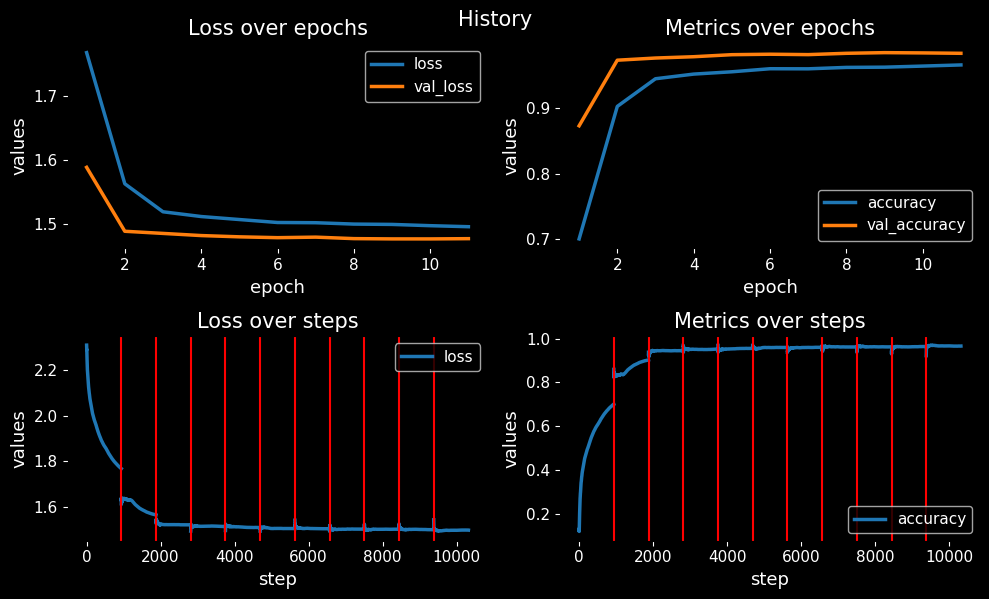

In [9]:
print(model.history)
model.plot_history()

In [10]:
print("Training config :")
print(pd.DataFrame(model.training_logs))
print("\nTraining parameters :")
print(pd.DataFrame(model.training_config))
print("\nTraining informations :")
print(pd.DataFrame(model.training_infos))


Training config :
          start           end       time  interrupted  start_epoch  final_epoch
0  1.742113e+09  1.742113e+09  32.639957        False            0           11

Training parameters :
   batch_size  add_early_stopping  patience  epochs  initial_epoch
0          64                True         3      15              0

Training informations :
          start           end       time  interrupted  start_epoch  final_epoch                     dataset  \
0  1.742113e+09  1.742113e+09  32.639957        False            0           11  {'train': {}, 'valid': {}}   

       additional_infos  
0  {'dataset': 'mnist'}  


## Prediction

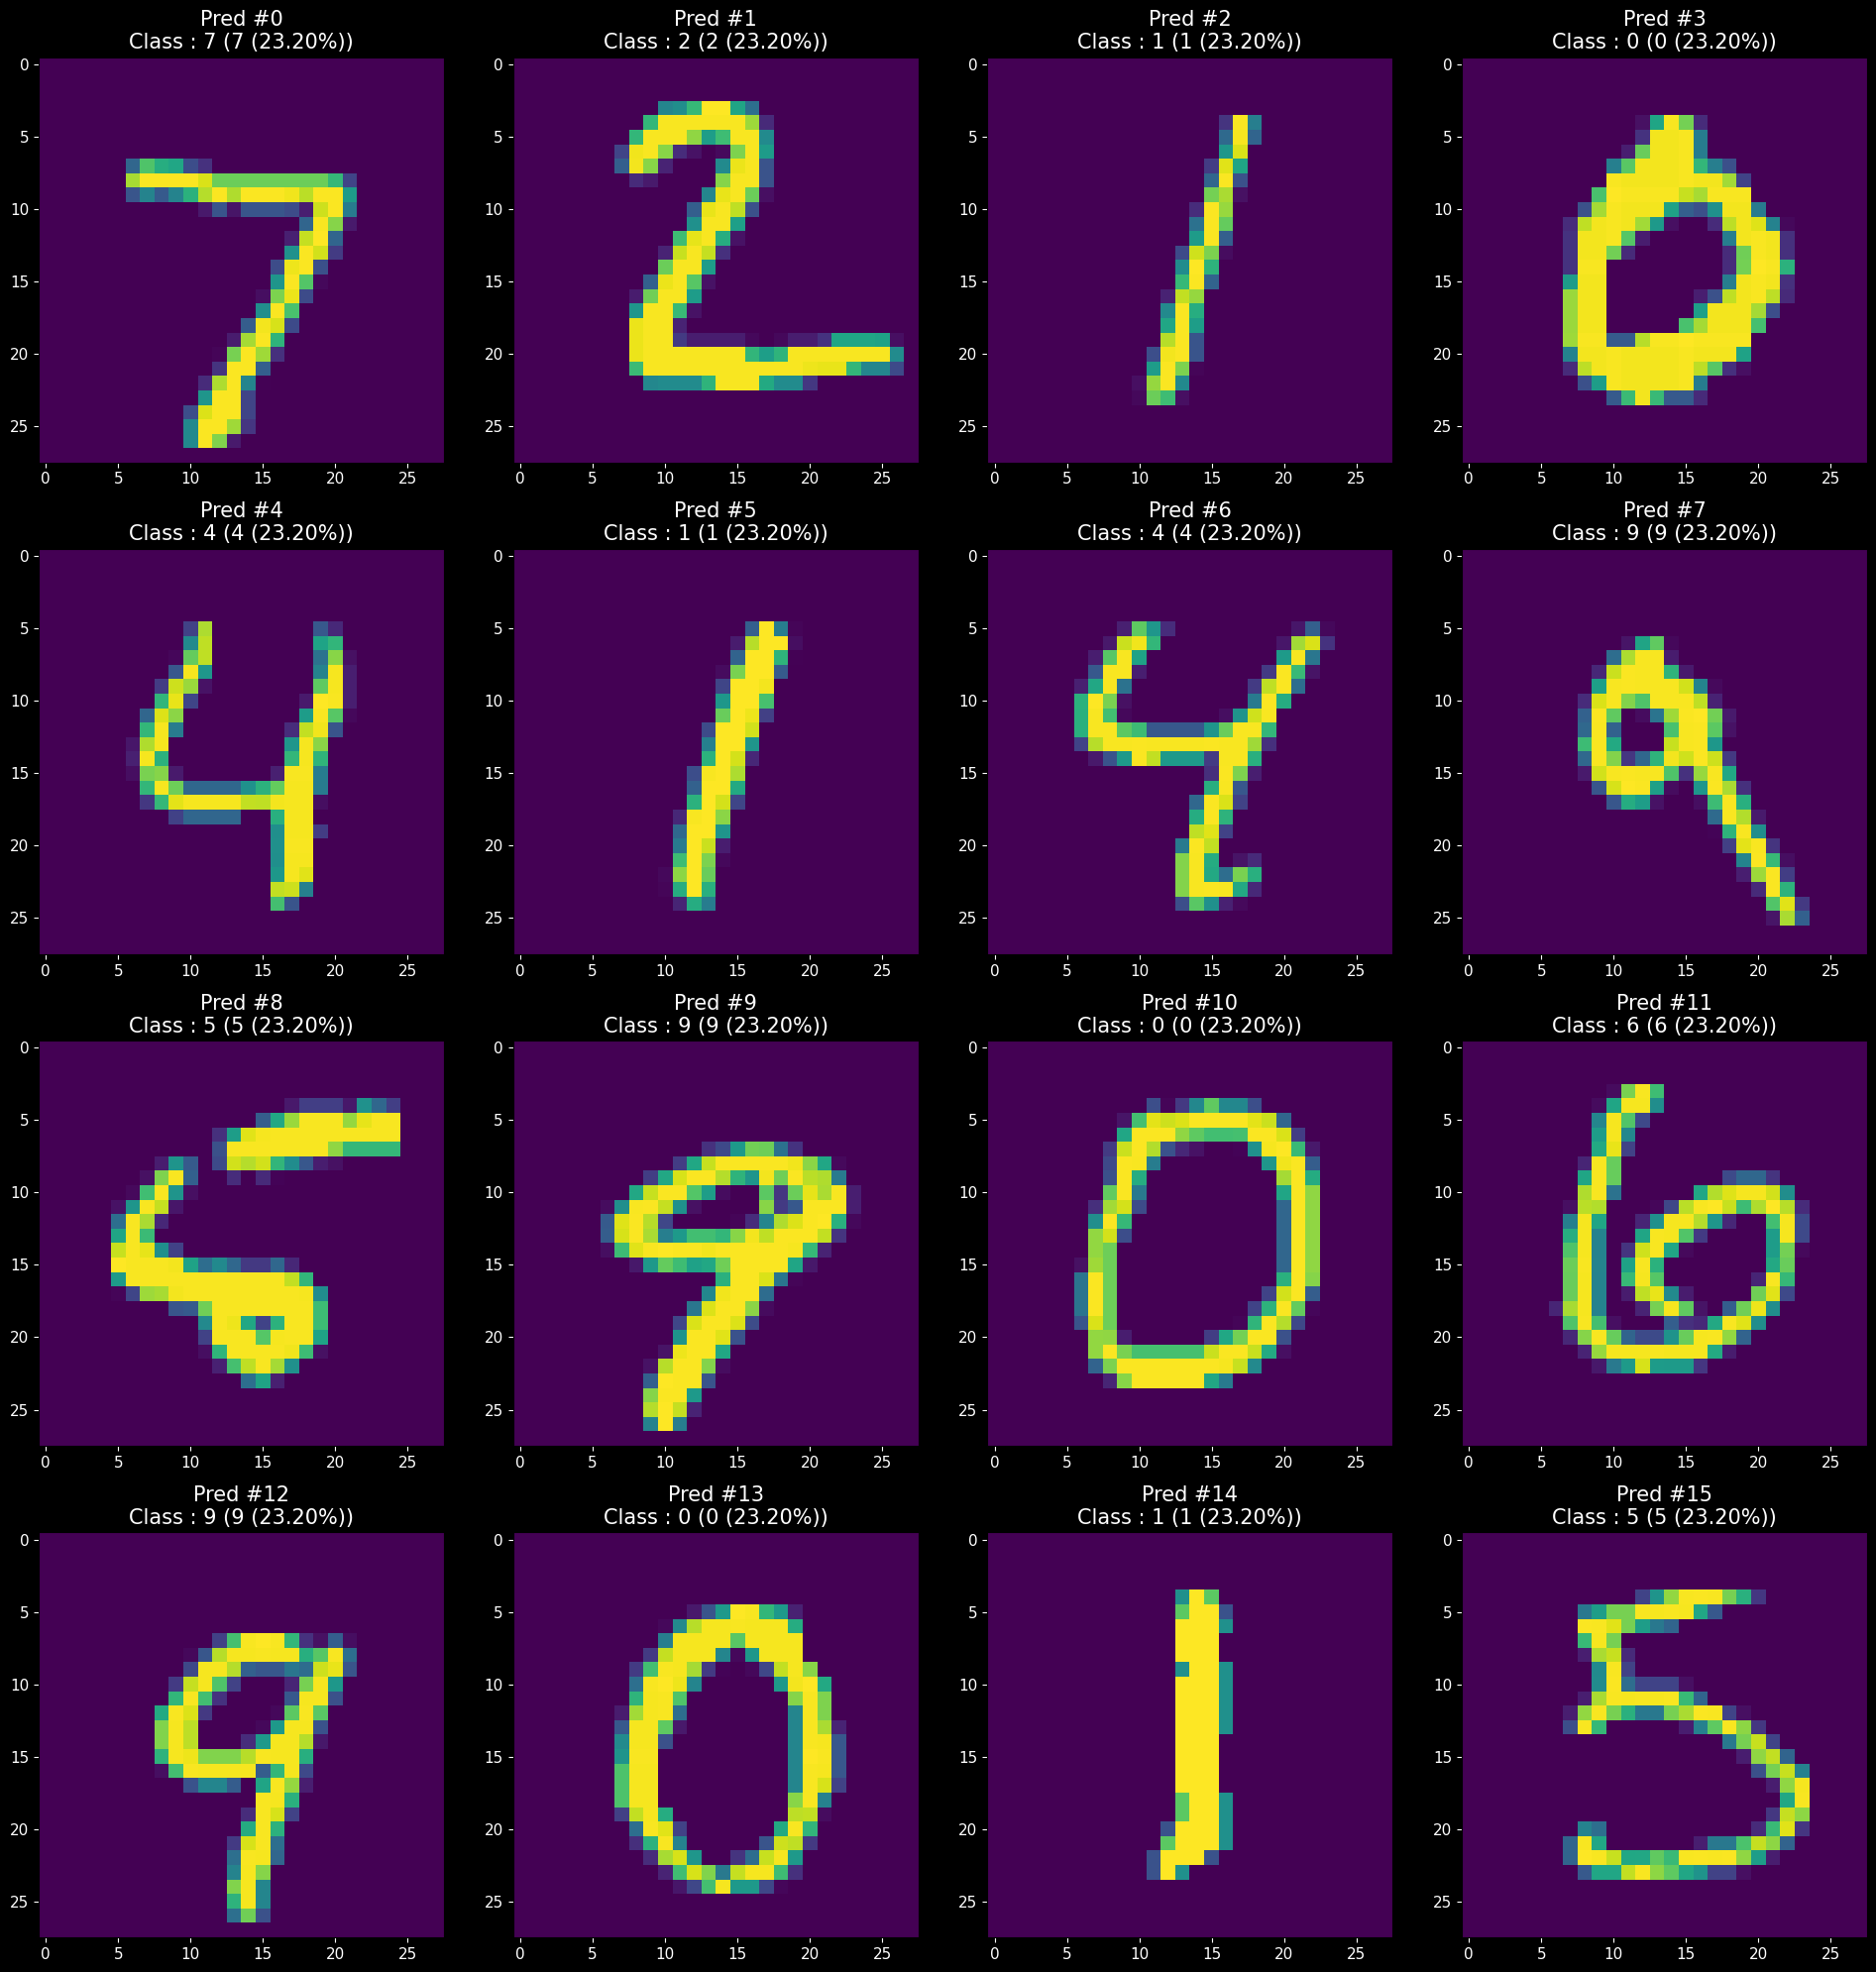

In [11]:
predictions = {}
for i, data in enumerate(zip(* valid)):
    if i >= 16: break
    image, label = model.prepare_data(* data)
    
    pred, score, probs = model.predict([image])[0]
    predictions['Pred #{}\nClass : {} ({} ({:.2f}%))'.format(i, label, pred, score * 100)] = image

plot_multiple(** predictions, ncols = 4, plot_type = 'imshow')

## Confusion matrix

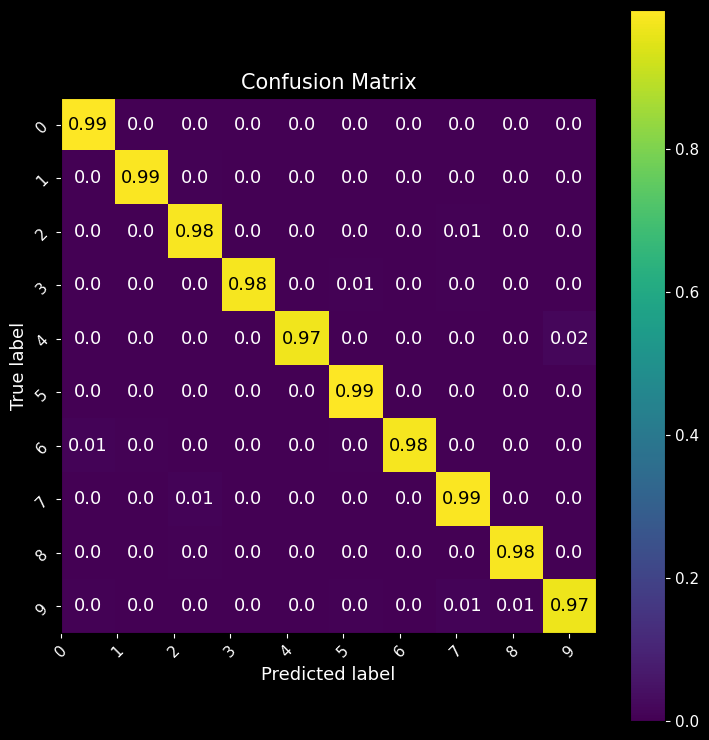

In [12]:
images, labels = [], []
for i, data in enumerate(zip(* valid)):
    image, label = data #model.prepare_data(* data)
    images.append(image)
    labels.append(label)

pred = model.predict(images)
pred = [p[0] for p in pred] # p[1] is the confidence score

plot_confusion_matrix(true = labels, pred = pred, norm = True)

## Test processing pipeline

When it is the first time you train a model, it is recommanded to assess the correctness of the processing pipeline. The below cells illustrate how to check the data statistics (values within a batch), as well as a visual analysis of the processing result. 

- The `get_dataset_config` returns the processing functions defined by the model that have to be forwarded to the `prepare_dataset` method
- The `prepare_dataset` instanciates a `tf.data.Dataset` instance based on the given data (also supports `pd.DataFrame` as well as other dataset formats)

This analysis demonstrates the correct alignment between images and labels, as well as correct value ranges for the image pixels (i.e., between 0 and 1)

In [13]:
from loggers import set_level

set_level('debug', 'utils.datasets') # the 2nd argument tells to only set the `datasets.*` module to debug

config = model.get_dataset_config('train', batch_size = 64)

ds_train = prepare_dataset(train, ** config)
test_dataset_time(ds_train, steps = 1000)

Original dataset : <_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
- Dataset after preparation : <_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset is cached
- Dataset is shuffled
- Dataset after batch : <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
- Dataset is prefetched


2025-03-16 09:23:19.545033: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
 94%|█████████████████████████████████████████████████████████████████████████▏    | 938/1000 [00:00<00:00, 2509.10it/s]


938 batches generated in 373 ms (2510.737 batch / sec)
- Initial batch time : 321 ms
- Average batch time : 398 μs
- Batch statistics   : [
    "shape : (32, 28, 28, 1) - min : 0.000 - max : 1.000 - mean : 0.125",
    "shape : (32,) - min : 0 - max : 9"
]



{'steps': 938,
 'batch_size': 64,
 'total time': 0.3735954761505127,
 'initial batch time': 0.321239709854126,
 'average batch time': 0.00039828942020310524}

Original dataset : <_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
- Dataset after preparation : <_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset is cached
- Dataset is shuffled
- Dataset after batch : <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
- Dataset is prefetched


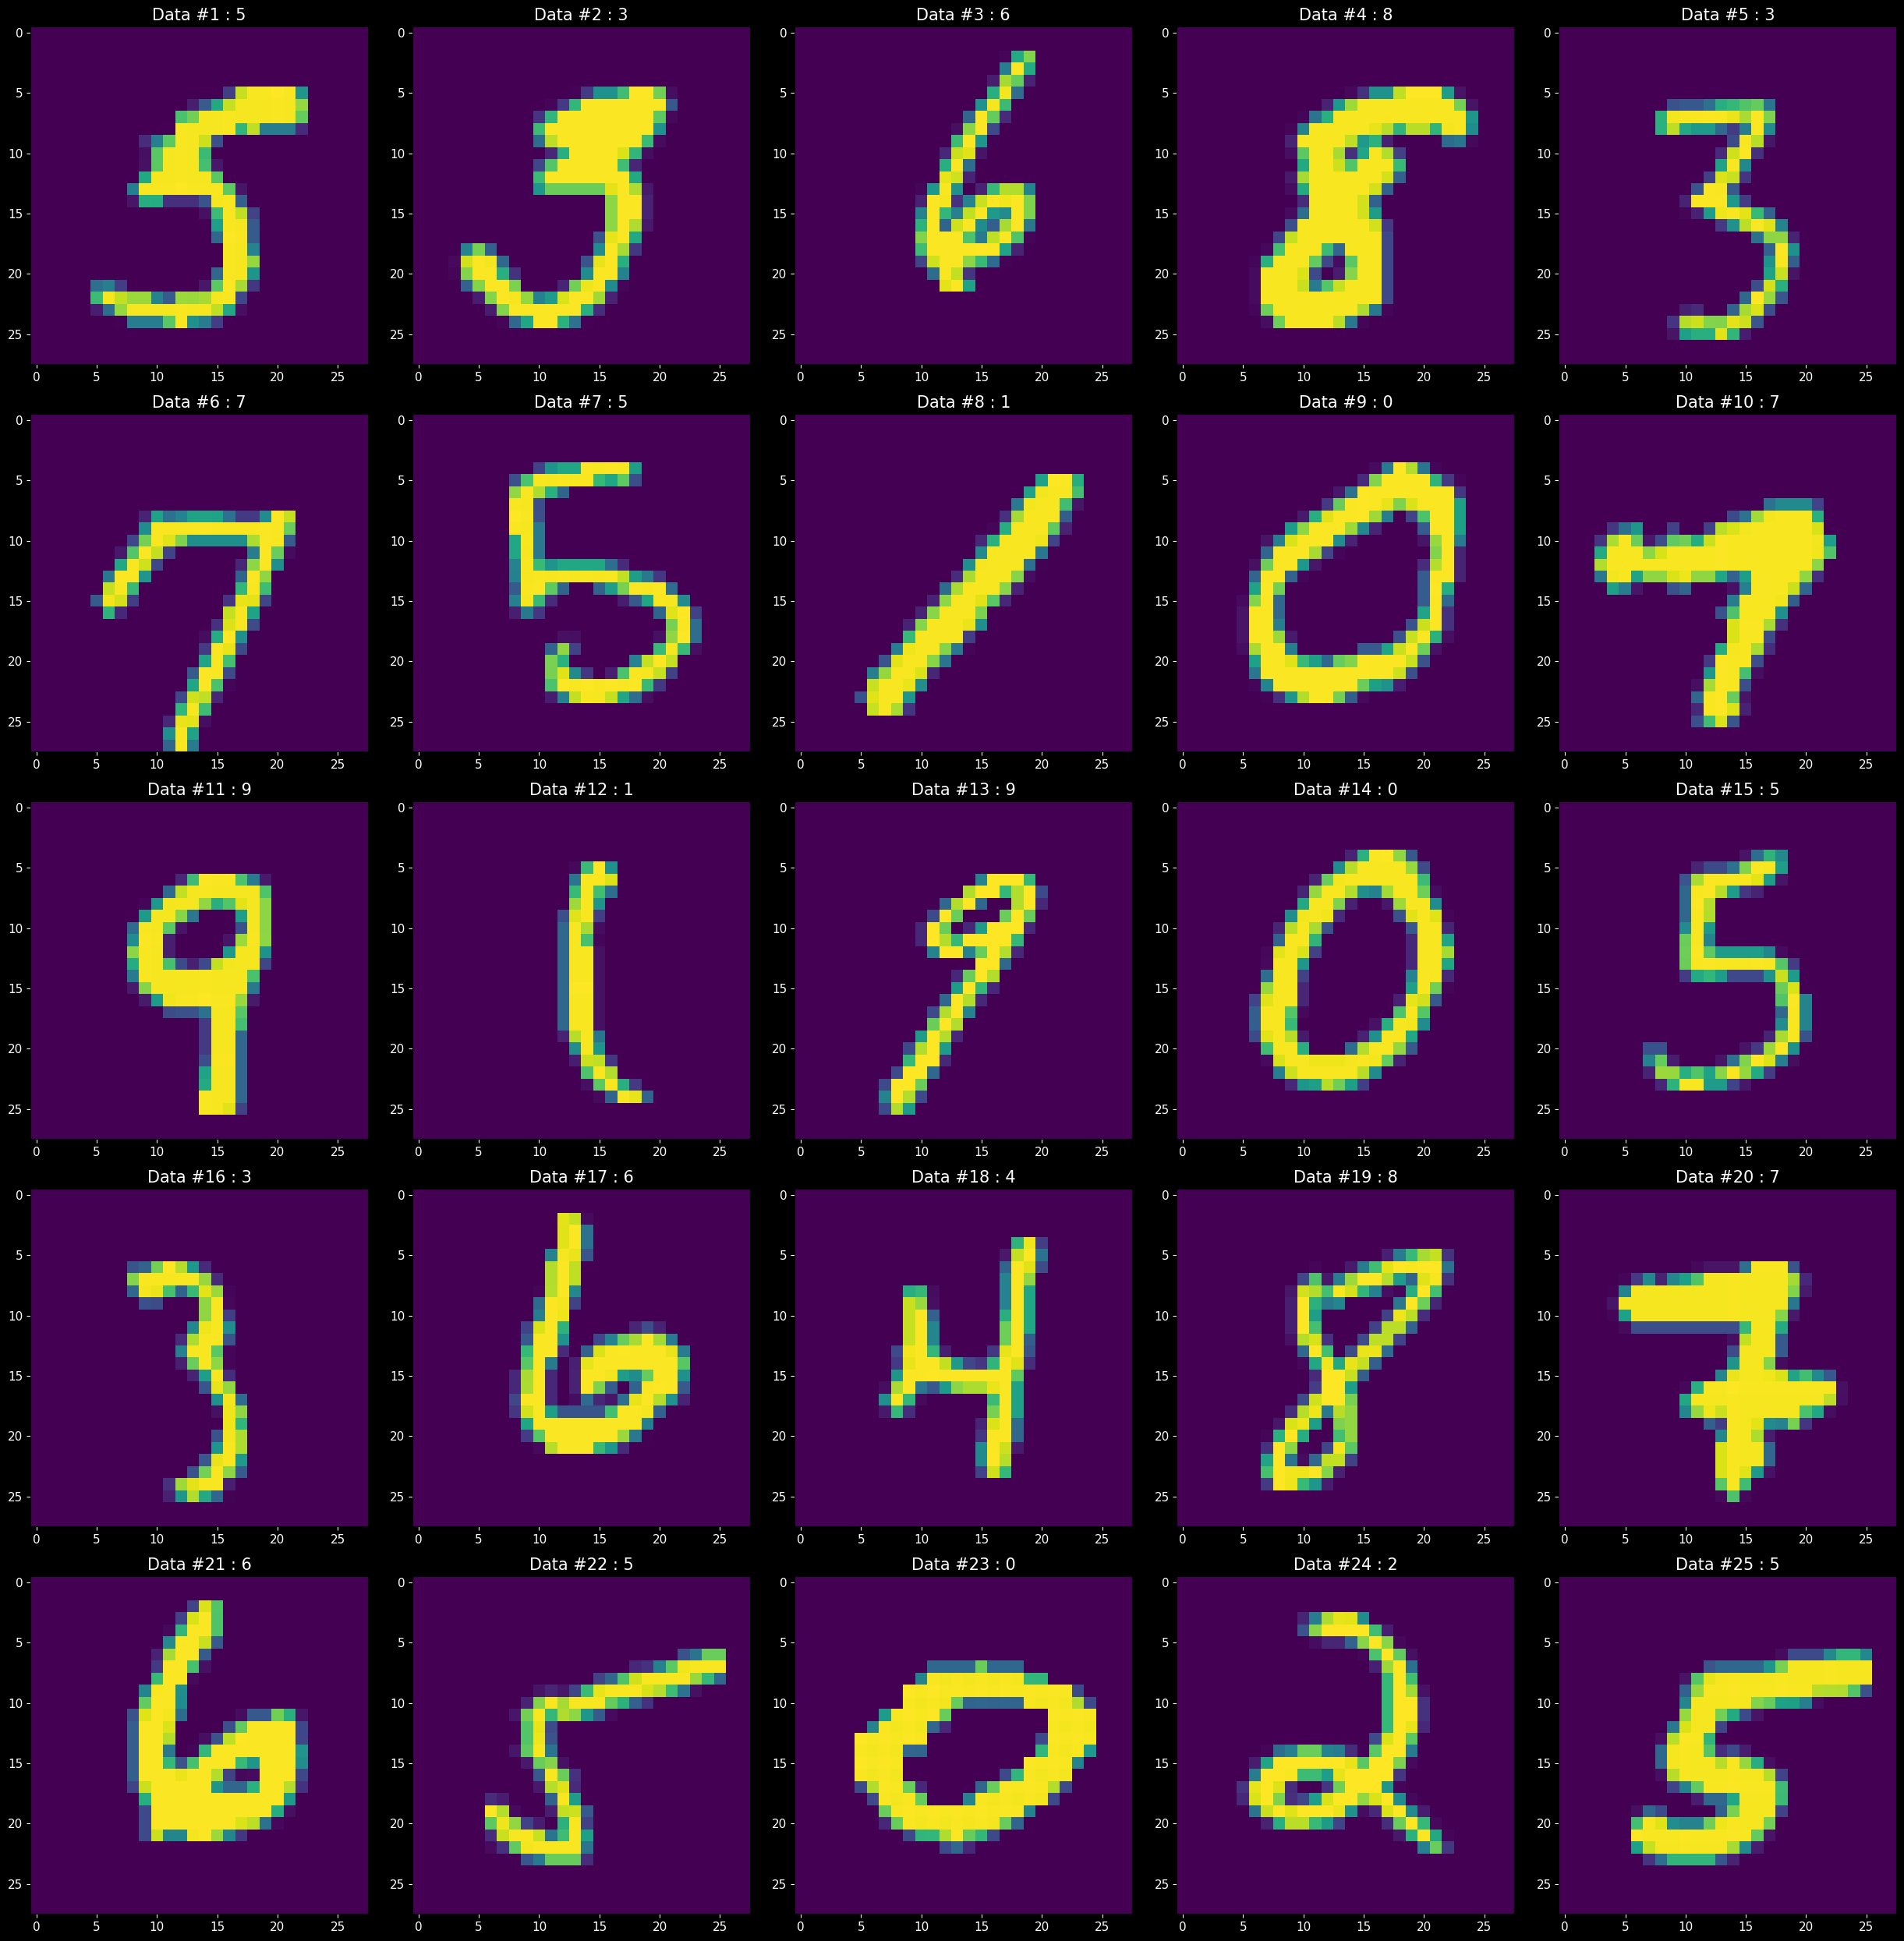

In [14]:
# Initializes the `tf.data.Dataset` instance with all defined processing functions
config = model.get_dataset_config('train', batch_size = 25)

ds_train = prepare_dataset(train, ** config)

# Get the 1st batch of data
inp, out = next(iter(ds_train))

data = {
    'Data #{} : {}'.format(i + 1, label) : img
    for i, (img, label) in enumerate(zip(inp, out))
}

plot_multiple(** data, ncols = 5, plot_type = 'imshow')